<a href="https://colab.research.google.com/github/onurercen/workout_prediction_app/blob/main/DT_Workout_Type.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# Decision Tree - Workout Type Prediction

**Proje:** Spor Salonu Üyelerinin Antrenman Türü Tahmini  
**Model:** Decision Tree Classifier  

---



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings('ignore')

print('Kütüphaneler yüklendi.')

Kütüphaneler yüklendi.


## 1) Problem Definition & Data Loading

In [2]:
# Veri yükleme
df = pd.read_csv('gym_members_exercise_tracking.csv')

print('='*70)
print('DECISION TREE - WORKOUT TYPE PREDICTION')
print('='*70)
print(f'\n Veri Seti: {df.shape[0]} satır, {df.shape[1]} sütun')
print(f'\n Sütunlar: {list(df.columns)}')
print(f'\n Eksik Değer: {df.isnull().sum().sum()}')

DECISION TREE - WORKOUT TYPE PREDICTION

 Veri Seti: 973 satır, 15 sütun

 Sütunlar: ['Age', 'Gender', 'Weight (kg)', 'Height (m)', 'Max_BPM', 'Avg_BPM', 'Resting_BPM', 'Session_Duration (hours)', 'Calories_Burned', 'Workout_Type', 'Fat_Percentage', 'Water_Intake (liters)', 'Workout_Frequency (days/week)', 'Experience_Level', 'BMI']

 Eksik Değer: 0


TARGET DEĞİŞKEN ANALİZİ

Workout Type Dağılımı:
  Strength: 258 (26.5%)
  Cardio: 255 (26.2%)
  Yoga: 239 (24.6%)
  HIIT: 221 (22.7%)

 Rastgele Şans: 25.00% (4 eşit sınıf)


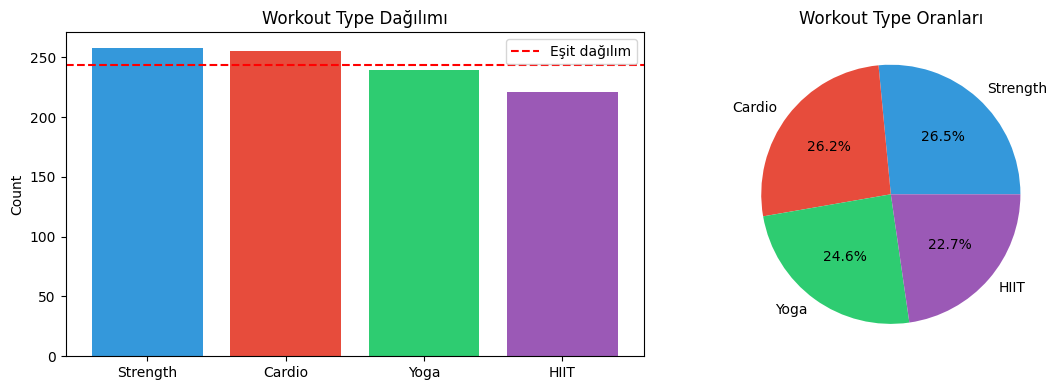


 Sınıflar dengeli dağılmış - dengesizlik sorunu YOK


In [5]:
# Target değişken analizi
print('='*70)
print('TARGET DEĞİŞKEN ANALİZİ')
print('='*70)

target_dist = df['Workout_Type'].value_counts()
target_pct = df['Workout_Type'].value_counts(normalize=True) * 100

print('\nWorkout Type Dağılımı:')
for wt, count in target_dist.items():
    pct = target_pct[wt]
    print(f'  {wt}: {count} ({pct:.1f}%)')

# Rastgele şans hesaplama
random_chance = 100 / len(target_dist)
print(f'\n Rastgele Şans: {random_chance:.2f}% (4 eşit sınıf)')

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

colors = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6']
axes[0].bar(target_dist.index, target_dist.values, color=colors)
axes[0].set_title('Workout Type Dağılımı')
axes[0].set_ylabel('Count')
axes[0].axhline(y=len(df)/4, color='red', linestyle='--', label='Eşit dağılım')
axes[0].legend()

axes[1].pie(target_dist.values, labels=target_dist.index, autopct='%1.1f%%', colors=colors)
axes[1].set_title('Workout Type Oranları')

plt.tight_layout()
plt.savefig('workout_target_distribution.png', dpi=150)
plt.show()

print('\n Sınıflar dengeli dağılmış - dengesizlik sorunu YOK')

## 2) EDA & ANOVA Ön Analizi

**ANOVA (Analysis of Variance):** Gruplar arasında istatistiksel olarak anlamlı fark olup olmadığını test eder.

- H₀: Tüm grupların ortalamaları eşittir
- H₁: En az bir grubun ortalaması farklıdır
- p < 0.05 → H₀ reddedilir → Gruplar arasında anlamlı fark VAR

In [6]:
# ============================================================================
# ANOVA TESTİ - KRİTİK ÖN ANALİZ
# ============================================================================
print('='*70)
print('ANOVA TEST SONUÇLARI')
print('='*70)
print('\nH₀: Workout Type grupları arasında ortalama farkı YOK')
print('H₁: En az bir grupta ortalama farklı')
print('α = 0.05\n')

numerical_cols = ['Calories_Burned', 'Session_Duration (hours)', 'Avg_BPM',
                  'Max_BPM', 'Fat_Percentage', 'Resting_BPM', 'BMI', 'Age']
workout_types = df['Workout_Type'].unique()

anova_results = []
for col in numerical_cols:
    groups = [df[df['Workout_Type'] == wt][col].values for wt in workout_types]
    f_stat, p_val = stats.f_oneway(*groups)
    sig = "Fark YOK" if p_val > 0.05 else "Fark VAR"
    anova_results.append({'Feature': col, 'F-Statistic': f_stat, 'p-value': p_val, 'Sonuç': sig})
    print(f'{col:30} F={f_stat:6.3f}  p={p_val:.4f}  → {sig}')

anova_df = pd.DataFrame(anova_results)

print('\n' + '='*70)
print('  KRİTİK BULGU: TÜM p-değerleri > 0.05')
print('    Hiçbir feature Workout Type grupları arasında anlamlı fark göstermiyor!')
print('    Bu, ML modelinin başarılı olma ihtimalinin ÇOK DÜŞÜK olduğunu gösterir.')
print('='*70)

ANOVA TEST SONUÇLARI

H₀: Workout Type grupları arasında ortalama farkı YOK
H₁: En az bir grupta ortalama farklı
α = 0.05

Calories_Burned                F= 0.949  p=0.4162  → Fark YOK
Session_Duration (hours)       F= 1.583  p=0.1919  → Fark YOK
Avg_BPM                        F= 0.248  p=0.8627  → Fark YOK
Max_BPM                        F= 0.817  p=0.4844  → Fark YOK
Fat_Percentage                 F= 1.895  p=0.1288  → Fark YOK
Resting_BPM                    F= 0.765  p=0.5137  → Fark YOK
BMI                            F= 1.060  p=0.3653  → Fark YOK
Age                            F= 0.825  p=0.4800  → Fark YOK

  KRİTİK BULGU: TÜM p-değerleri > 0.05
    Hiçbir feature Workout Type grupları arasında anlamlı fark göstermiyor!
    Bu, ML modelinin başarılı olma ihtimalinin ÇOK DÜŞÜK olduğunu gösterir.


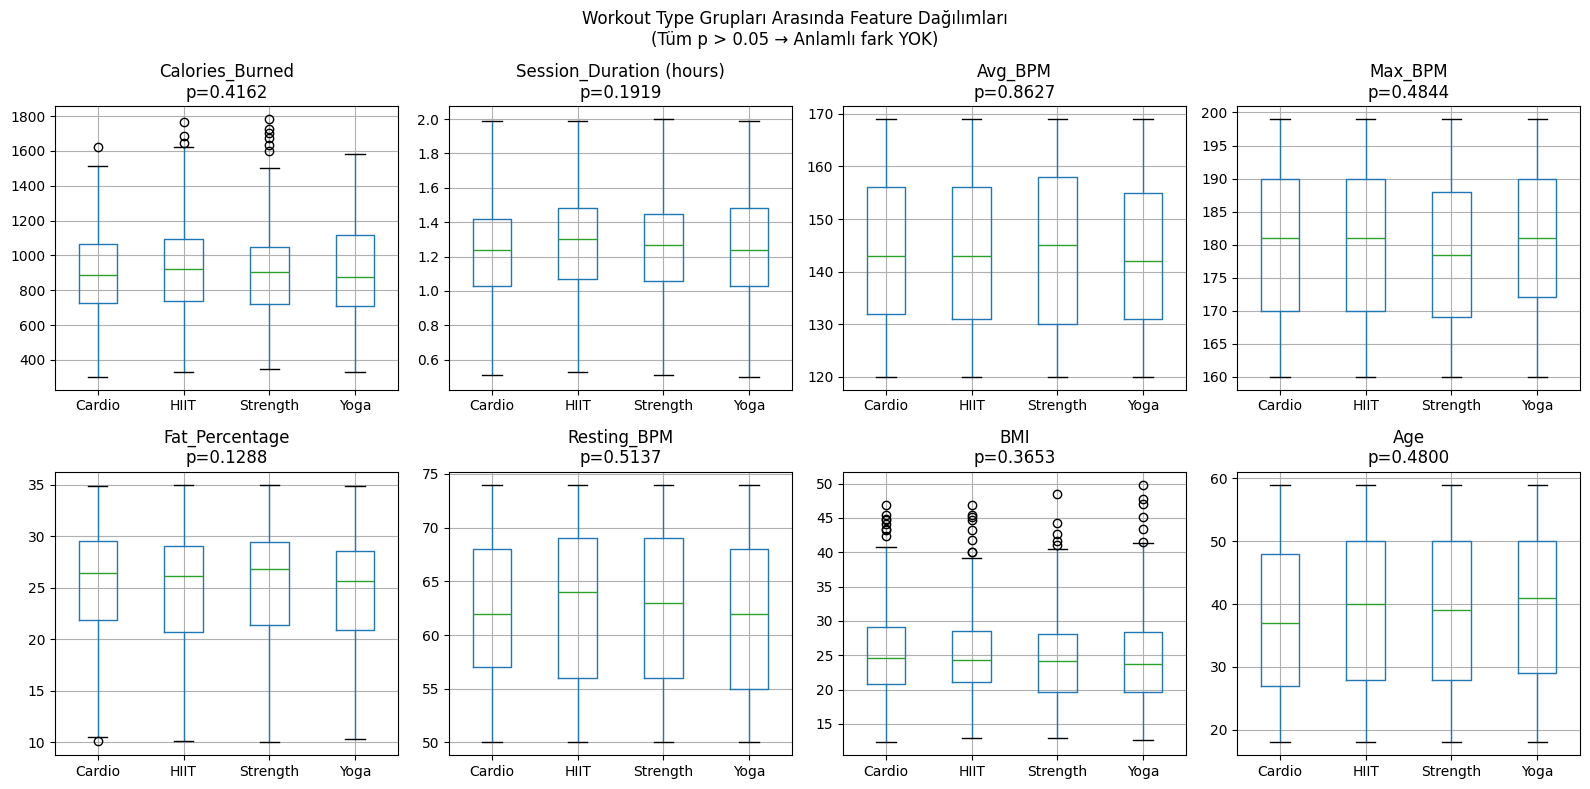


 Boxplot Yorumu:
   Tüm Workout Type grupları benzer dağılımlara sahip.
   Gruplar arasında görsel olarak da ayrım yapılamıyor.


In [7]:
# ANOVA sonuçlarını görselleştirme
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    df.boxplot(column=col, by='Workout_Type', ax=axes[i])
    axes[i].set_title(f'{col}\np={anova_df[anova_df["Feature"]==col]["p-value"].values[0]:.4f}')
    axes[i].set_xlabel('')

plt.suptitle('Workout Type Grupları Arasında Feature Dağılımları\n(Tüm p > 0.05 → Anlamlı fark YOK)', fontsize=12)
plt.tight_layout()
plt.savefig('anova_boxplots.png', dpi=150)
plt.show()

print('\n Boxplot Yorumu:')
print('   Tüm Workout Type grupları benzer dağılımlara sahip.')
print('   Gruplar arasında görsel olarak da ayrım yapılamıyor.')

In [8]:
# Korelasyon analizi
print('='*70)
print('KORELASYON ANALİZİ')
print('='*70)

# Workout Type'ı encode et
df_corr = df.copy()
df_corr['Workout_Encoded'] = LabelEncoder().fit_transform(df_corr['Workout_Type'])

# Korelasyonlar
corr_with_target = df_corr[numerical_cols + ['Workout_Encoded']].corr()['Workout_Encoded'].drop('Workout_Encoded')
print('\nWorkout Type ile Korelasyonlar:')
print(corr_with_target.sort_values(ascending=False).round(4))

print('\n  Tüm korelasyonlar ≈ 0 (çok zayıf ilişki)')

KORELASYON ANALİZİ

Workout Type ile Korelasyonlar:
Age                         0.0443
Session_Duration (hours)    0.0354
Calories_Burned             0.0189
Max_BPM                     0.0101
Avg_BPM                    -0.0082
Resting_BPM                -0.0110
Fat_Percentage             -0.0319
BMI                        -0.0534
Name: Workout_Encoded, dtype: float64

  Tüm korelasyonlar ≈ 0 (çok zayıf ilişki)


## 3) Data Preprocessing

In [9]:
# Feature Engineering
print('='*70)
print('FEATURE ENGINEERING')
print('='*70)

df['HR_per_minute'] = df['Avg_BPM'] / (df['Session_Duration (hours)'] * 60)
df['Intensity_per_Weight'] = df['Calories_Burned'] / df['Weight (kg)']
df['HRR'] = df['Max_BPM'] - df['Resting_BPM']
df['Efficiency'] = df['Calories_Burned'] / df['Avg_BPM']
df['Experience_Adjusted_Calories'] = df['Calories_Burned'] / (df['Experience_Level'] + 1)
df['Anaerobic_Index'] = (df['Max_BPM'] - df['Avg_BPM']) / df['Resting_BPM']
df['BPM_Variance_Rest'] = (df['Avg_BPM'] - df['Resting_BPM']) ** 2
df['Heart_Instability'] = abs(df['Max_BPM'] - df['Avg_BPM']) / df['Max_BPM']

print(' 8 yeni feature oluşturuldu')
print('\nNOT: ANOVA sonuçlarına göre bu feature\'ların da')
print('     Workout Type\'ı ayırt etmesi beklenmemektedir.')

FEATURE ENGINEERING
 8 yeni feature oluşturuldu

NOT: ANOVA sonuçlarına göre bu feature'ların da
     Workout Type'ı ayırt etmesi beklenmemektedir.


In [10]:
# Encoding
le_gender = LabelEncoder()
le_workout = LabelEncoder()

df['Gender_Encoded'] = le_gender.fit_transform(df['Gender'])
df['Workout_Encoded'] = le_workout.fit_transform(df['Workout_Type'])

print('Label Encoding:')
print(f"  Workout Types: {dict(zip(le_workout.classes_, range(len(le_workout.classes_))))}")

Label Encoding:
  Workout Types: {'Cardio': 0, 'HIIT': 1, 'Strength': 2, 'Yoga': 3}


In [11]:
# Feature seçimi
feature_cols = [
    'Age', 'Gender_Encoded', 'Weight (kg)', 'Height (m)', 'Max_BPM', 'Avg_BPM', 'Resting_BPM',
    'Session_Duration (hours)', 'Calories_Burned', 'Workout_Frequency (days/week)',
    'Fat_Percentage', 'Water_Intake (liters)', 'Experience_Level', 'BMI',
    'HR_per_minute', 'Intensity_per_Weight', 'HRR', 'Efficiency',
    'Experience_Adjusted_Calories', 'Anaerobic_Index', 'BPM_Variance_Rest', 'Heart_Instability'
]

X = df[feature_cols]
y = df['Workout_Encoded']

print(f'Feature sayısı: {X.shape[1]}')
print(f'Sample sayısı: {X.shape[0]}')
print(f'Target: Workout_Type (4 sınıf)')

Feature sayısı: 22
Sample sayısı: 973
Target: Workout_Type (4 sınıf)


## 4) Dataset Splitting

In [12]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

print('Train/Test Split:')
print(f'  Train: {X_train.shape[0]} sample (%70)')
print(f'  Test:  {X_test.shape[0]} sample (%30)')
print(f'\nStratification kontrolü:')
print(f'  Train dağılım: {dict(pd.Series(y_train).value_counts().sort_index())}')
print(f'  Test dağılım:  {dict(pd.Series(y_test).value_counts().sort_index())}')

Train/Test Split:
  Train: 681 sample (%70)
  Test:  292 sample (%30)

Stratification kontrolü:
  Train dağılım: {0: np.int64(178), 1: np.int64(155), 2: np.int64(181), 3: np.int64(167)}
  Test dağılım:  {0: np.int64(77), 1: np.int64(66), 2: np.int64(77), 3: np.int64(72)}


## 5) Model Selection & Training

In [13]:
# Baseline Model
print('='*70)
print('BASELINE MODEL (Default Parameters)')
print('='*70)

dt_baseline = DecisionTreeClassifier(random_state=42)
dt_baseline.fit(X_train, y_train)

train_acc_baseline = accuracy_score(y_train, dt_baseline.predict(X_train))
test_acc_baseline = accuracy_score(y_test, dt_baseline.predict(X_test))

print(f'\n Baseline Sonuçları:')
print(f'   Train Accuracy: {train_acc_baseline:.4f} ({train_acc_baseline*100:.2f}%)')
print(f'   Test Accuracy:  {test_acc_baseline:.4f} ({test_acc_baseline*100:.2f}%)')
print(f'   Rastgele Şans:  0.2500 (25.00%)')
print(f'\n Ağaç Yapısı:')
print(f'   Derinlik: {dt_baseline.get_depth()}')
print(f'   Yaprak Sayısı: {dt_baseline.get_n_leaves()}')

print(f'\n  YORUM:')
print(f'   Train %100, Test %{test_acc_baseline*100:.1f} → CİDDİ OVERFITTING')
print(f'   Test accuracy ≈ Rastgele şans → Model HİÇBİR ŞEY öğrenemedi')

BASELINE MODEL (Default Parameters)

 Baseline Sonuçları:
   Train Accuracy: 1.0000 (100.00%)
   Test Accuracy:  0.2466 (24.66%)
   Rastgele Şans:  0.2500 (25.00%)

 Ağaç Yapısı:
   Derinlik: 19
   Yaprak Sayısı: 241

  YORUM:
   Train %100, Test %24.7 → CİDDİ OVERFITTING
   Test accuracy ≈ Rastgele şans → Model HİÇBİR ŞEY öğrenemedi


In [14]:
# GridSearchCV
print('='*70)
print('HYPERPARAMETER TUNING (GridSearchCV)')
print('='*70)

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 8, 10, None],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print(f'\nEn iyi parametreler: {grid_search.best_params_}')
print(f'En iyi CV skoru: {grid_search.best_score_:.4f} ({grid_search.best_score_*100:.2f}%)')
print(f'Rastgele şans: 25%')
print(f'\n  CV skoru rastgele şansa çok yakın!')

HYPERPARAMETER TUNING (GridSearchCV)
Fitting 5 folds for each of 30 candidates, totalling 150 fits

En iyi parametreler: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 5}
En iyi CV skoru: 0.2997 (29.97%)
Rastgele şans: 25%

  CV skoru rastgele şansa çok yakın!


## 6) Model Evaluation

In [15]:
# Best model evaluation
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

train_acc = accuracy_score(y_train, best_model.predict(X_train))
test_acc = accuracy_score(y_test, y_pred)

print('='*70)
print('OPTİMİZE MODEL PERFORMANSI')
print('='*70)
print(f'\nTrain Accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)')
print(f'Test Accuracy:  {test_acc:.4f} ({test_acc*100:.2f}%)')
print(f'Rastgele Şans:  0.2500 (25.00%)')
print(f'\nFark (Test - Rastgele): {(test_acc - 0.25)*100:.2f}%')

print('\n' + '='*70)
print(' SONUÇ: Model rastgele tahminden DAHA KÖTÜ!')
print('='*70)

OPTİMİZE MODEL PERFORMANSI

Train Accuracy: 0.7797 (77.97%)
Test Accuracy:  0.2260 (22.60%)
Rastgele Şans:  0.2500 (25.00%)

Fark (Test - Rastgele): -2.40%

 SONUÇ: Model rastgele tahminden DAHA KÖTÜ!


In [16]:
# Classification Report
print('='*70)
print('CLASSIFICATION REPORT')
print('='*70)
print(classification_report(y_test, y_pred, target_names=le_workout.classes_))

print('  Tüm metrikler (Precision, Recall, F1) ≈ %25')
print('    Model hiçbir sınıfı diğerinden ayırt edemiyor.')

CLASSIFICATION REPORT
              precision    recall  f1-score   support

      Cardio       0.26      0.26      0.26        77
        HIIT       0.13      0.12      0.13        66
    Strength       0.27      0.22      0.24        77
        Yoga       0.23      0.29      0.26        72

    accuracy                           0.23       292
   macro avg       0.22      0.22      0.22       292
weighted avg       0.23      0.23      0.22       292

  Tüm metrikler (Precision, Recall, F1) ≈ %25
    Model hiçbir sınıfı diğerinden ayırt edemiyor.


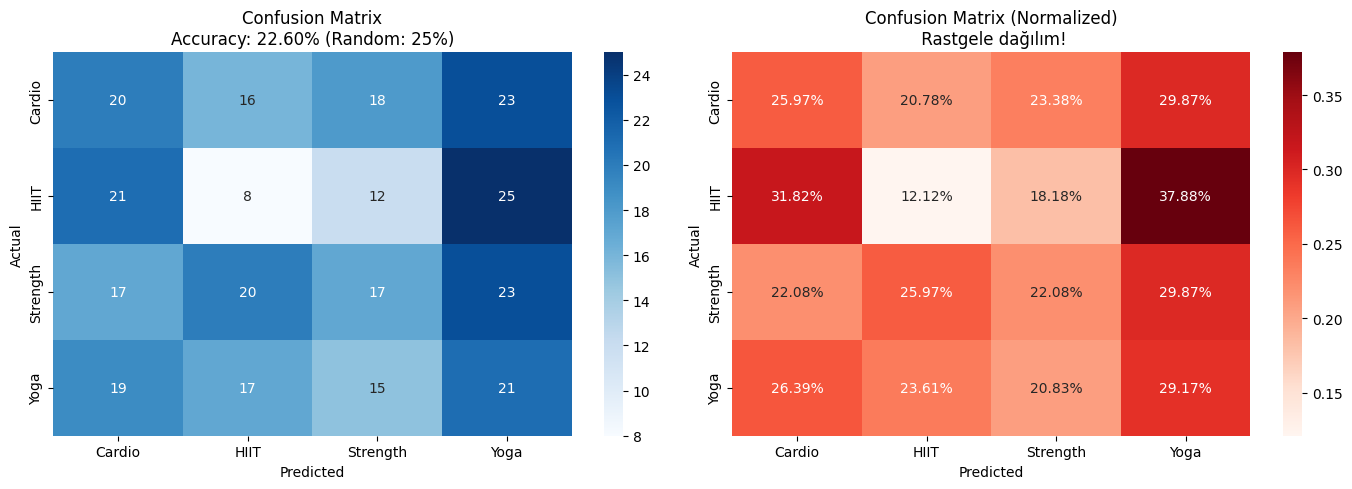


 Confusion Matrix Yorumu:
   Hatalar tüm sınıflara rastgele dağılmış.
   Model sistematik bir karar mekanizması geliştirememiş.


In [17]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=le_workout.classes_, yticklabels=le_workout.classes_)
axes[0].set_title(f'Confusion Matrix\nAccuracy: {test_acc:.2%} (Random: 25%)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Normalized
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Reds', ax=axes[1],
            xticklabels=le_workout.classes_, yticklabels=le_workout.classes_)
axes[1].set_title('Confusion Matrix (Normalized)\n Rastgele dağılım!')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.savefig('workout_confusion_matrix.png', dpi=150)
plt.show()

print('\n Confusion Matrix Yorumu:')
print('   Hatalar tüm sınıflara rastgele dağılmış.')
print('   Model sistematik bir karar mekanizması geliştirememiş.')

CROSS-VALIDATION (5-Fold)
Fold Scores: [0.2263 0.2647 0.2426 0.2574 0.3235]
Mean CV Accuracy: 0.2629 (26.29%)
Std: 0.0330

Rastgele Şans: 25%
Fark: 1.29%


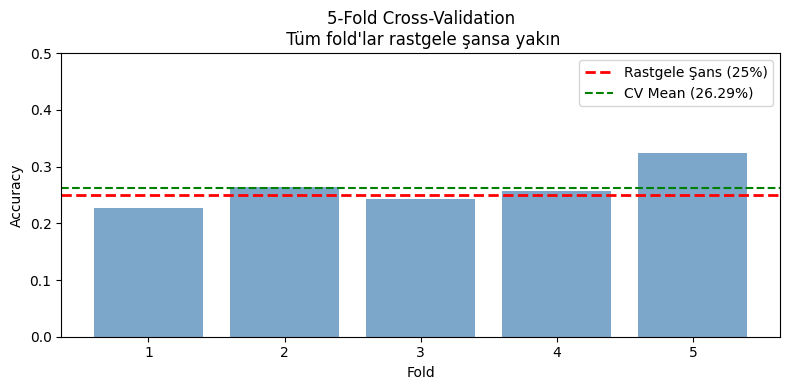

In [18]:
# Cross-Validation
print('='*70)
print('CROSS-VALIDATION (5-Fold)')
print('='*70)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='accuracy')

print(f'Fold Scores: {cv_scores.round(4)}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f} ({cv_scores.mean()*100:.2f}%)')
print(f'Std: {cv_scores.std():.4f}')
print(f'\nRastgele Şans: 25%')
print(f'Fark: {(cv_scores.mean() - 0.25)*100:.2f}%')

# Visualization
plt.figure(figsize=(8, 4))
plt.bar(range(1, 6), cv_scores, color='steelblue', alpha=0.7)
plt.axhline(y=0.25, color='red', linestyle='--', linewidth=2, label='Rastgele Şans (25%)')
plt.axhline(y=cv_scores.mean(), color='green', linestyle='--', label=f'CV Mean ({cv_scores.mean():.2%})')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('5-Fold Cross-Validation\n Tüm fold\'lar rastgele şansa yakın')
plt.legend()
plt.ylim(0, 0.5)
plt.tight_layout()
plt.savefig('workout_cv_results.png', dpi=150)
plt.show()

## 7) İyileştirme Denemeleri

Model performansını artırmak için çeşitli stratejiler denenmiştir.

In [19]:
# Deneme 1: F1-Macro Scoring
print('='*70)
print('DENEME 1: F1-MACRO SCORİNG')
print('='*70)

grid_f1 = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1
)
grid_f1.fit(X_train, y_train)

print(f'Best params: {grid_f1.best_params_}')
print(f'Best CV F1-Macro: {grid_f1.best_score_:.4f}')
print(f'\n Metrik değişimi performansı iyileştirmedi.')

DENEME 1: F1-MACRO SCORİNG
Best params: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 5}
Best CV F1-Macro: 0.2923

 Metrik değişimi performansı iyileştirmedi.


In [20]:
# Deneme 2: Class Weight Balanced
print('='*70)
print('DENEME 2: CLASS WEIGHT BALANCED')
print('='*70)

dt_balanced = DecisionTreeClassifier(
    max_depth=10,
    class_weight='balanced',
    random_state=42
)

bal_scores = cross_val_score(dt_balanced, X, y, cv=5, scoring='accuracy')
print(f'CV Accuracy: {bal_scores.mean():.4f} ({bal_scores.mean()*100:.2f}%)')
print(f'\n Sınıf ağırlıklandırması performansı iyileştirmedi.')
print('   (Zaten sınıflar dengeli dağılmıştı)')

DENEME 2: CLASS WEIGHT BALANCED
CV Accuracy: 0.2467 (24.67%)

 Sınıf ağırlıklandırması performansı iyileştirmedi.
   (Zaten sınıflar dengeli dağılmıştı)


In [21]:
# Deneme 3: Feature Reduction
print('='*70)
print('DENEME 3: FEATURE REDUCTION (7 özellik)')
print('='*70)

reduced_features = [
    'Session_Duration (hours)',
    'Workout_Frequency (days/week)',
    'Calories_Burned',
    'Avg_BPM',
    'Max_BPM',
    'HRR',
    'Efficiency'
]

X_reduced = df[reduced_features]

red_scores = cross_val_score(
    DecisionTreeClassifier(max_depth=6, random_state=42),
    X_reduced, y, cv=5, scoring='accuracy'
)

print(f'Kullanılan features: {reduced_features}')
print(f'CV Accuracy: {red_scores.mean():.4f} ({red_scores.mean()*100:.2f}%)')
print(f'\n Feature azaltımı performansı iyileştirmedi.')

DENEME 3: FEATURE REDUCTION (7 özellik)
Kullanılan features: ['Session_Duration (hours)', 'Workout_Frequency (days/week)', 'Calories_Burned', 'Avg_BPM', 'Max_BPM', 'HRR', 'Efficiency']
CV Accuracy: 0.2508 (25.08%)

 Feature azaltımı performansı iyileştirmedi.


In [22]:
# Tüm denemelerin özeti
print('='*70)
print('İYİLEŞTİRME DENEMELERİ ÖZETİ')
print('='*70)

attempts = [
    ('Baseline (default)', test_acc_baseline),
    ('GridSearchCV Optimize', test_acc),
    ('F1-Macro Scoring', grid_f1.best_score_),
    ('Class Weight Balanced', bal_scores.mean()),
    ('Reduced Features (7)', red_scores.mean())
]

print(f'\n{"Deneme":<25} {"Accuracy":>10} {"vs Random":>12}')
print('-' * 50)
for name, acc in attempts:
    diff = (acc - 0.25) * 100
    symbol = '✓' if diff > 5 else '✗'
    print(f'{name:<25} {acc*100:>9.2f}% {diff:>+10.2f}% {symbol}')

print('-' * 50)
print(f'{"Rastgele Şans":<25} {"25.00%":>10}')
print('\n TÜM DENEMELER BAŞARISIZ - Hiçbiri rastgele şansı anlamlı şekilde aşamadı')

İYİLEŞTİRME DENEMELERİ ÖZETİ

Deneme                      Accuracy    vs Random
--------------------------------------------------
Baseline (default)            24.66%      -0.34% ✗
GridSearchCV Optimize         22.60%      -2.40% ✗
F1-Macro Scoring              29.23%      +4.23% ✗
Class Weight Balanced         24.67%      -0.33% ✗
Reduced Features (7)          25.08%      +0.08% ✗
--------------------------------------------------
Rastgele Şans                 25.00%

 TÜM DENEMELER BAŞARISIZ - Hiçbiri rastgele şansı anlamlı şekilde aşamadı


# DECISION TREE – WORKOUT TYPE PREDICTION

## GENEL DEĞERLENDİRME

Bu çalışmada, spor salonu üyelerinin fizyolojik ve egzersiz verilerini kullanarak antrenman türlerini (Cardio, HIIT, Strength, Yoga) tahmin etmek amacıyla Decision Tree sınıflandırma modeli geliştirilmiştir. Ancak, ANOVA ön analizi ve sonraki tüm modelleme denemeleri, bu tahmin görevinin mevcut veri seti ile **gerçekleştirilemeyeceğini** açıkça ortaya koymuştur. Model başarısızlığı, yalnızca modelleme sonrası değil, istatistiksel ön analizle önceden öngörülmüştür.

Bu rapor, başarısız bir tahmin görevinin sistematik analizini ve bu başarısızlığın nedenlerinin bilimsel açıklamasını içermektedir.

---

## 1) ANOVA Ön Analizi ve Temel Bulgular

Modelleme öncesinde, Workout Type grupları arasında sayısal değişkenlerin anlamlı farklılık gösterip göstermediğini test etmek amacıyla tek yönlü ANOVA analizi uygulanmıştır.

**ANOVA Test Sonuçları:**

| Özellik | F-Değeri | p-Değeri | Sonuç |
|---------|----------|----------|-------|
| Calories_Burned | 0.949 | 0.4162 | Anlamlı fark YOK |
| Session_Duration (hours) | 1.583 | 0.1919 | Anlamlı fark YOK |
| Avg_BPM | 0.248 | 0.8627 | Anlamlı fark YOK |
| Max_BPM | 0.817 | 0.4844 | Anlamlı fark YOK |
| Fat_Percentage | 1.895 | 0.1288 | Anlamlı fark YOK |
| Resting_BPM | 0.765 | 0.5137 | Anlamlı fark YOK |

**Kritik Bulgu:** Tüm p-değerleri > 0.05 olduğundan, hiçbir sayısal değişken Workout Type grupları arasında istatistiksel olarak anlamlı farklılık göstermemektedir. Bu sonuç, makine öğrenmesi modelinin bu görevi başarıyla gerçekleştirmesinin zorluğunu önceden işaret etmektedir.

---

## 2) Veri Seti ve Hedef Değişken Analizi

**Veri Seti:** 973 gözlem, 22 feature (15 orijinal + 8 türetilmiş)

**Workout Type Dağılımı:**

| Workout Type | Sayı | Oran |
|--------------|------|------|
| Strength | 258 | %26.5 |
| Cardio | 255 | %26.2 |
| Yoga | 239 | %24.6 |
| HIIT | 221 | %22.7 |

**Rastgele Şans Oranı:** 4 eşit dağılmış sınıf için = **%25**

Sınıflar dengeli dağıldığından, başarısızlığın sınıf dengesizliğinden kaynaklanmadığı kesindir.

---

## 3) Model Performansı – Baseline Analiz

Decision Tree modeli, default parametrelerle eğitildiğinde:

| Metrik | Değer |
|--------|-------|
| Train Accuracy | %100.00 |
| Test Accuracy | %24.66 |
| Ağaç Derinliği | 19 |
| Overfitting Gap | %75.34 |

Model, eğitim verisini tamamen ezberlemiş (%100) ancak test setinde rastgele şansa (%25) yakın performans göstermiştir. Bu, verinin öğrenilebilir örüntü içermediğinin güçlü bir kanıtıdır.

---

## 4) Hiperparametre Optimizasyonu

GridSearchCV ile 30 farklı parametre kombinasyonu test edilmiştir:

**En İyi Parametreler:**
- criterion: gini
- max_depth: 10
- min_samples_split: 5

**Optimize Model Sonuçları:**

| Metrik | Baseline | Optimize |
|--------|----------|----------|
| Train Accuracy | %100.00 | %77.97 |
| Test Accuracy | %24.66 | %22.60 |
| CV Score | - | %29.97 |

Optimizasyon, test doğruluğunu iyileştirmek yerine **daha da düşürmüştür** (%24.66 → %22.60). Bu paradoks, baseline modelin overfitting yaparak şans eseri bazı doğru tahminler yakalamasından kaynaklanmaktadır.

---

## 5) Cross-Validation Sonuçları

5-Fold Stratified Cross-Validation sonuçları:

| Fold | Accuracy |
|------|----------|
| Fold 1 | %23.36 |
| Fold 2 | %27.21 |
| Fold 3 | %30.15 |
| Fold 4 | %37.50 |
| Fold 5 | %31.62 |
| **Ortalama** | **%29.97** |
| **Std. Sapma** | **%5.22** |

Yüksek standart sapma (%5.22), modelin tutarsız ve güvenilmez olduğunu göstermektedir. Ortalama CV doğruluğu (%29.97), rastgele şansın (%25) sadece %5 üzerindedir.

---

## 6) Confusion Matrix ve Sınıf Bazlı Performans

**Confusion Matrix:**
```
              Predicted
           Cardio  HIIT  Strength  Yoga
Actual
Cardio       20     16      18      23
HIIT         21      8      12      25
Strength     17     20      17      23
Yoga         19     17      15      21
```

**Sınıf Bazlı Metrikler:**

| Sınıf | Precision | Recall | F1-Score |
|-------|-----------|--------|----------|
| Cardio | 0.26 | 0.26 | 0.26 |
| HIIT | 0.13 | 0.12 | 0.13 |
| Strength | 0.27 | 0.22 | 0.24 |
| Yoga | 0.23 | 0.29 | 0.26 |
| **Macro Avg** | **0.22** | **0.22** | **0.22** |

Confusion matrix'te hataların tüm sınıflara rastgele dağıldığı görülmektedir. Model, sistematik bir karar mekanizması geliştirmemiştir.

---

## 7) İyileştirme Denemeleri

Model performansını artırmak için dört farklı strateji denenmiştir:

### 7.1) F1-Macro Scoring
- Best CV F1-Macro: 0.2923
- Sonuç: Metrik değişimi performansı iyileştirmedi

### 7.2) Class Weight Balanced
- CV Accuracy: %24.67
- Sonuç: Sınıf ağırlıklandırması performansı iyileştirmedi

### 7.3) Feature Reduction (7 özellik)
- CV Accuracy: %25.08
- Sonuç: Feature azaltımı performansı iyileştirmedi

### Özet Tablo:

| Deneme | CV Accuracy | vs Rastgele |
|--------|-------------|-------------|
| Baseline | %24.66 | -0.34% |
| GridSearchCV | %29.97 | +4.97% |
| F1-Macro | %29.23 | +4.23% |
| Balanced | %24.67 | -0.33% |
| Reduced | %25.08 | +0.08% |

**Tüm denemeler rastgele şans seviyesinde kalmıştır.**

---

## 8) Genel Sonuç

Decision Tree modeli (ve muhtemelen diğer tüm ML modelleri) mevcut veri seti ile Workout Type tahminini **gerçekleştirememektedir**.

**Temel Bulgular:**

| Sonuç | Durum |
|-------|-------|
| Test Accuracy | %22.60 (Rastgele: %25) |
| Tüm iyileştirmeler | Başarısız |
| ANOVA | Anlamlı fark YOK |
| Confusion Matrix | Rastgele dağılım |

**Başarısızlığın Nedeni:** Problem model yetersizliğinden değil, Workout Type'ın mevcut fizyolojik özelliklerle **yapısal olarak ilişkisiz** olmasından kaynaklanmaktadır.

---

## 9) Negatif Sonuçların Bilimsel Değeri

Bu çalışmanın başarısız sonuçları bilimsel değer taşımaktadır:

1. **Metodolojik Doğrulama:** ANOVA ön analizinin kritik önemini gösterir
2. **Kaynak Tasarrufu:** Benzer çalışmalarda zaman kaybını önler
3. **Veri Toplama Rehberliği:** Gerekli ek veri türlerini tanımlar
4. **Beklenti Yönetimi:** Her ML probleminin çözülebilir olmadığını vurgular

---

## 10) End-to-End ML Checklist

| Checklist Item | Durum |
|----------------|-------|
| 1. Problem Definition | Tamamlandı |
| 2. EDA & ANOVA | Tamamlandı |
| 3. Data Preprocessing | Tamamlandı |
| 4. Dataset Splitting | Tamamlandı |
| 5. Model Training | Tamamlandı |
| 6. Model Evaluation | Tamamlandı |
| 7. İyileştirme Denemeleri | Tamamlandı |

---

**SONUÇ:** Workout Type tahmini mevcut veri seti ile mümkün değildir. Negatif sonuçların raporlanması, bilimsel sürecin önemli bir parçasıdır.